In [1]:
from Plate_sim import *

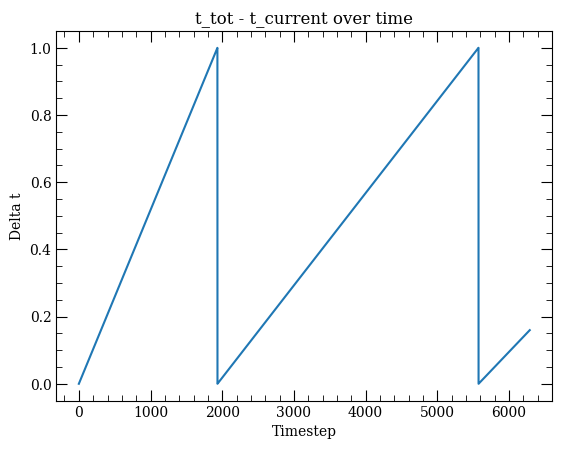

In [2]:
file_path = "last_10_percent.xls"  # even if it's called .xls, it is a CSV
delta_times = compute_time_differences(file_path)

plt.plot(delta_times)
plt.title("t_tot - t_current over time")
plt.xlabel("Timestep")
plt.ylabel("Delta t")
plt.show()

In [3]:
print(len(delta_times))

6291


In [4]:
# 1. Create 5x5 ground map
nx, ny = 5, 5
x_coords = np.linspace(0, 4, nx)
y_coords = np.linspace(0, 4, ny)

terrain_map = np.zeros((nx, ny))  # start flat

# Set 2 mountains
terrain_map[1, 1] = 50.0  # Mountain 1
terrain_map[3, 3] = 60.0  # Mountain 2

# 2. Define source at center
source_positions = [(2, 2, 50)]  # (x_idx, y_idx, depth in meters)

# 3. Define sensors (optional but needed by API)
sensor_positions = [(1, 1), (3, 3)]  # Place sensors on mountains

# 4. Simulation parameters
total_time_yr = 2    # 10 time steps
dt_yr = 0.2           # 10 steps exactly

tectonic_emissions_df, burst_map_times, measurement_map_times, ground_accumulation_times = run_full_surface_hole_simulation_from_data(
    terrain_map,
    x_coords,
    y_coords,
    delta_times,
    source_positions,
    sensor_positions,
    hole_burst_threshold=1e-2,
    gamma_conversion=1e5,
    surface_diffusion_sigma=5,
    altitude_attraction_strength=5,
    v_upward=0.01
)

100%|██████████| 6291/6291 [00:29<00:00, 209.99it/s]


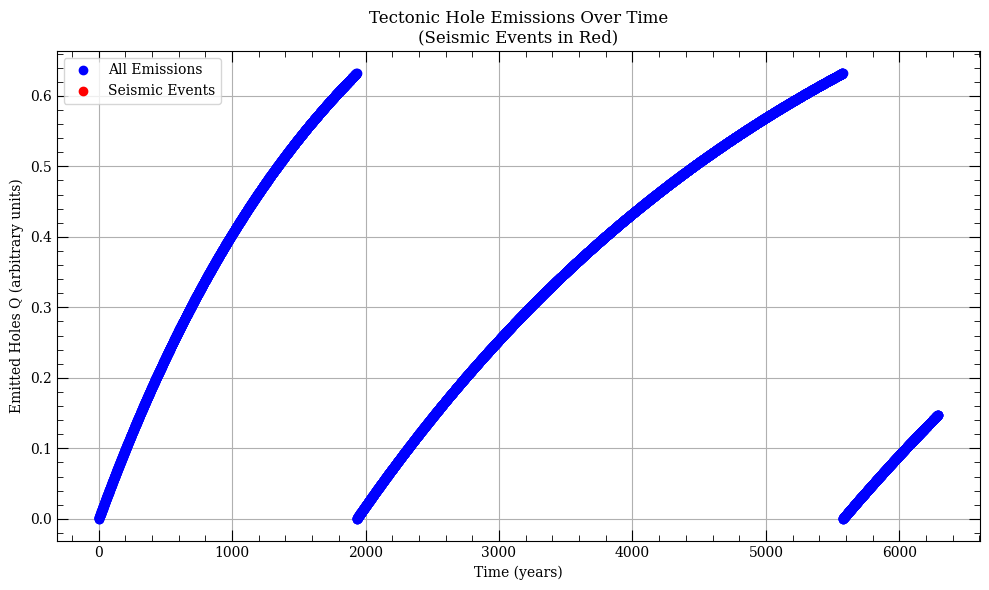

In [5]:
# --- Create seismic mask ---
# Detect seismic points where seismic_output > 0
seismic_mask = tectonic_emissions_df["seismic_output"] > 0.0

# --- Plot ---
plt.figure(figsize=(10,6))

# 1. Plot all points in blue
plt.plot(tectonic_emissions_df["time_years"],
         tectonic_emissions_df["emission_Q"],
         marker="o", linestyle="", color="blue", label="All Emissions")

# 2. Overplot seismic events in red
plt.plot(tectonic_emissions_df.loc[seismic_mask, "time_years"],
         tectonic_emissions_df.loc[seismic_mask, "emission_Q"],
         marker="o", linestyle="", color="red", label="Seismic Events")

plt.title("Tectonic Hole Emissions Over Time\n(Seismic Events in Red)")
plt.xlabel("Time (years)")
plt.ylabel("Emitted Holes Q (arbitrary units)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

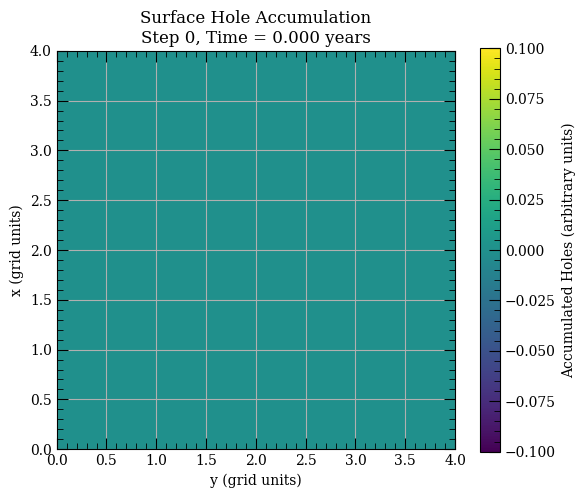

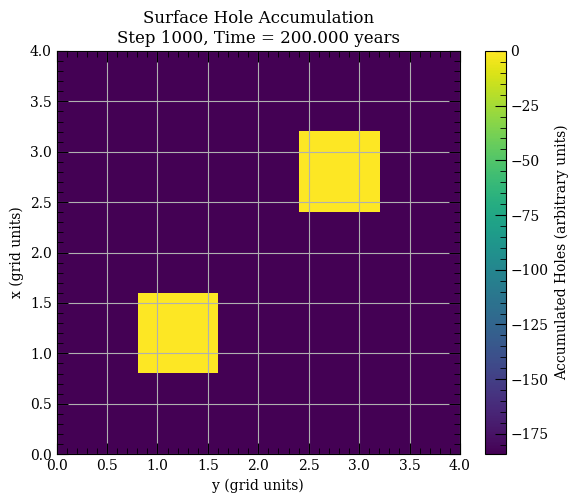

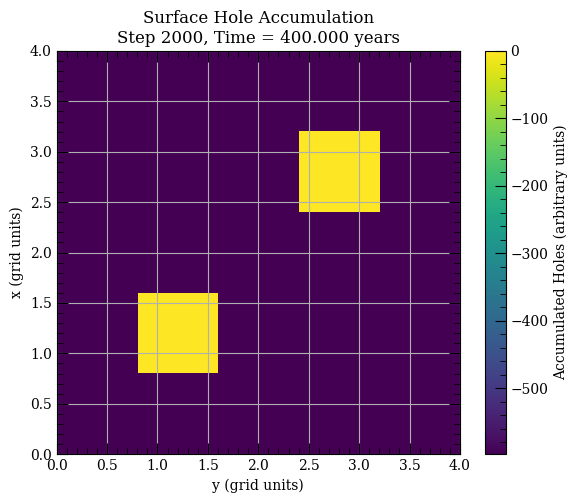

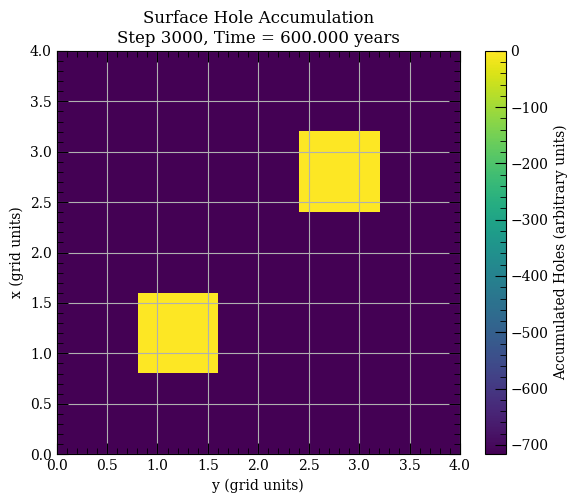

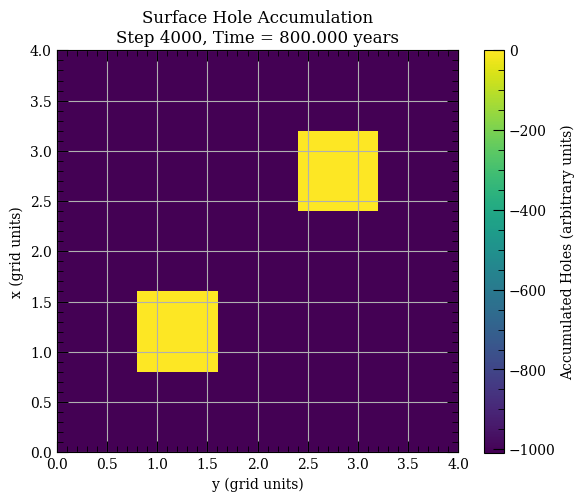

In [6]:
# 6. Plot surface accumulation map at each time step
nt = ground_accumulation_times.shape[0]

for t_idx in range(5):
    plt.figure(figsize=(6,5))
    plt.imshow(ground_accumulation_times[t_idx*1000], cmap="viridis", origin="lower", extent=[y_coords.min(), y_coords.max(), x_coords.min(), x_coords.max()])
    plt.colorbar(label="Accumulated Holes (arbitrary units)")
    plt.title(f"Surface Hole Accumulation\nStep {t_idx*1000}, Time = {t_idx*1000 * dt_yr:.3f} years")
    plt.xlabel("y (grid units)")
    plt.ylabel("x (grid units)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

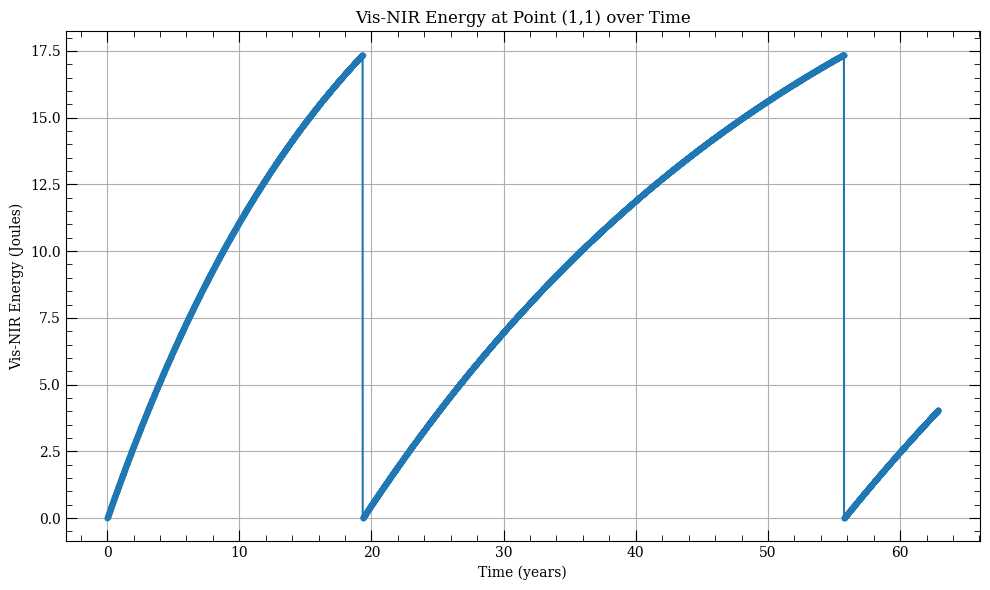

In [7]:
nt = burst_map_times.shape[0]
nx, ny = burst_map_times.shape[1], burst_map_times.shape[2]

# Initialize arrays to store time and Vis-NIR energy at point (1,1)
times = np.arange(nt) * 0.01  # assuming 0.01 years per timestep
visnir_at_point = np.zeros(nt)

# Loop through each time step and extract Vis-NIR at (1,1)
for t_idx in range(nt):
    burst_info = burst_map_times[t_idx, 1, 1]  # <-- at point (1,1)
    E_visnir = burst_info.get("E_visnir_J", 0.0)
    visnir_at_point[t_idx] = E_visnir

# --- Plot the evolution of Vis-NIR energy at (1,1) ---
plt.figure(figsize=(10,6))
plt.plot(times, visnir_at_point, marker="o", markersize=3, linestyle="-")
plt.title("Vis-NIR Energy at Point (1,1) over Time")
plt.xlabel("Time (years)")
plt.ylabel("Vis-NIR Energy (Joules)")
plt.grid(True)
plt.tight_layout()
plt.show()

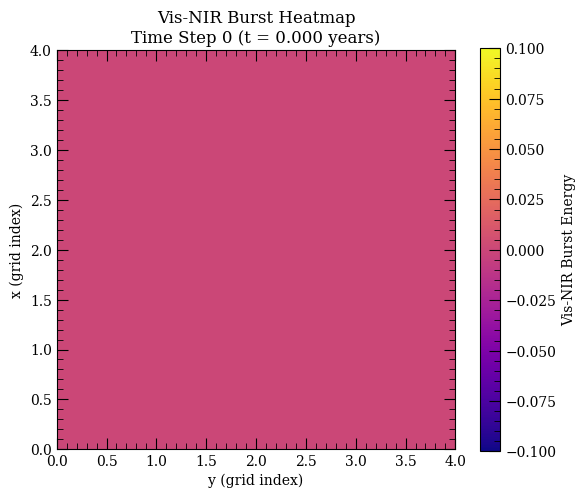

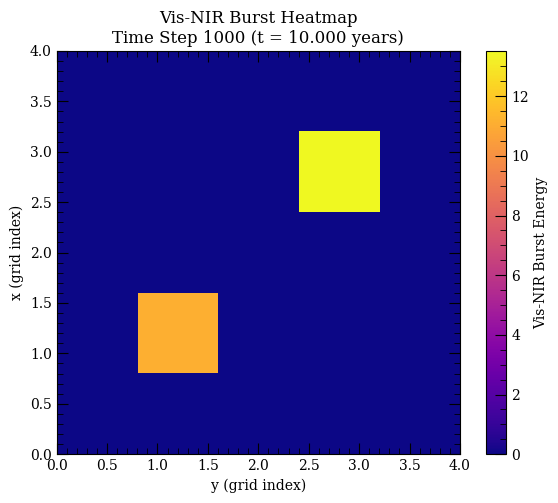

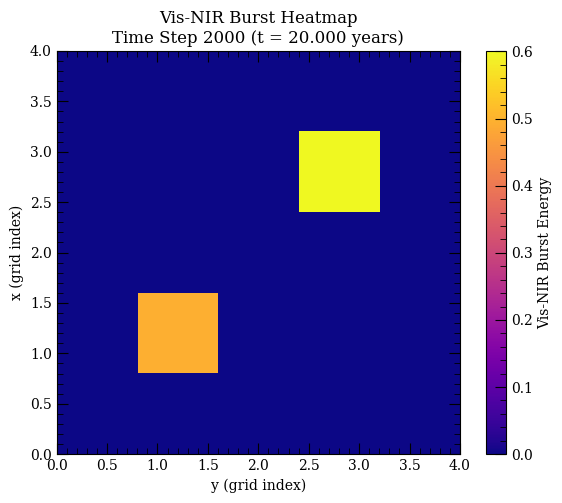

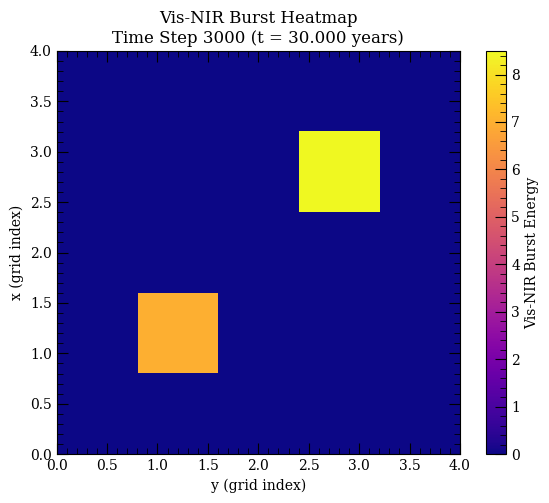

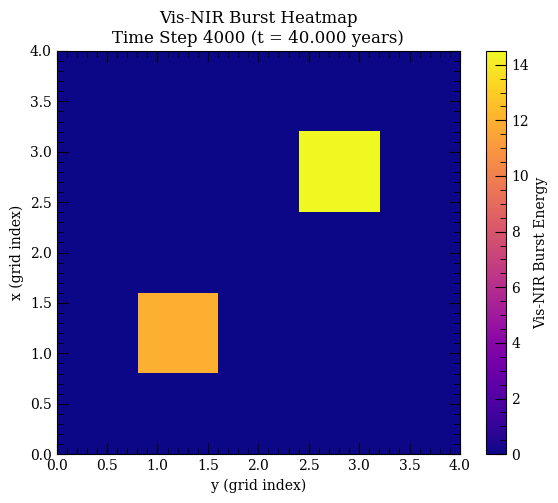

In [8]:
nt = burst_map_times.shape[0]
nx, ny = burst_map_times.shape[1], burst_map_times.shape[2]

# Loop through each time step and plot
for t_idx in [0,1000,2000,3000,4000]:
    visnir_energy_map = np.zeros((nx, ny))

    # Build Vis-NIR burst map for this timestep
    for ix in range(nx):
        for iy in range(ny):
            burst_info = burst_map_times[t_idx, ix, iy]
            E_visnir = burst_info.get("E_visnir_J", 0.0)
            visnir_energy_map[ix, iy] = E_visnir

    # --- Plot the heatmap for this time step ---
    plt.figure(figsize=(6,5))
    plt.imshow(visnir_energy_map, origin="lower", cmap="plasma", extent=[0, ny-1, 0, nx-1])
    plt.colorbar(label="Vis-NIR Burst Energy")
    plt.title(f"Vis-NIR Burst Heatmap\nTime Step {t_idx} (t = {t_idx * 0.01:.3f} years)")
    plt.xlabel("y (grid index)")
    plt.ylabel("x (grid index)")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

[[ 0.86523189+0.j          0.        +0.01058201j -0.27959229+0.j        ]
 [ 0.        -0.01058201j  0.02116402+0.j          0.        +0.0037868j ]
 [-0.27959229+0.j          0.        -0.0037868j   0.11360409+0.j        ]]
[[ 0.86523189+0.j          0.        +0.01058201j -0.27959229+0.j        ]
 [ 0.        -0.01058201j  0.02116402+0.j          0.        +0.0037868j ]
 [-0.27959229+0.j          0.        -0.0037868j   0.11360409+0.j        ]]
[[ 0.86515847+0.j          0.00413255+0.01059786j -0.27962321-0.00086468j]
 [ 0.00413255-0.01059786j  0.02119572+0.j         -0.00144114+0.00378819j]
 [-0.27962321+0.00086468j -0.00144114-0.00378819j  0.11364581+0.j        ]]
[[ 0.86513435+0.j          0.00476302+0.01060306j -0.27963336-0.0009967j ]
 [ 0.00476302-0.01060306j  0.02120613+0.j         -0.00166116+0.00378865j]
 [-0.27963336+0.0009967j  -0.00166116-0.00378865j  0.11365952+0.j        ]]
[[ 0.86507205+0.j          0.00609709+0.01061651j -0.27965957-0.00127617j]
 [ 0.00609709-0.01061

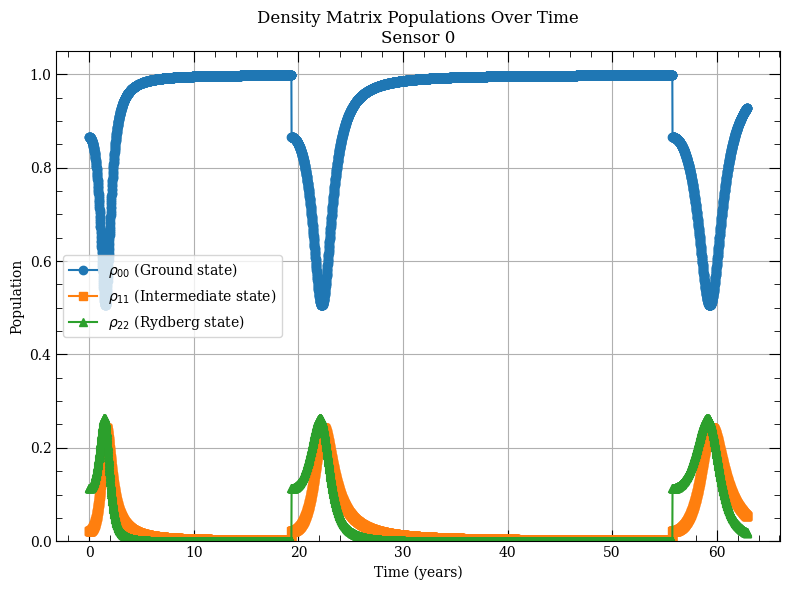

In [9]:
# --- Choose the sensor to plot ---
sensor_idx = 0  # first sensor

nt = measurement_map_times.shape[0]

# Initialize arrays
rho_00 = np.zeros(nt)
rho_11 = np.zeros(nt)
rho_22 = np.zeros(nt)

for t_idx in range(nt):
    rho = measurement_map_times[t_idx, sensor_idx]
    print(rho)

    if rho is not None:
        rho_matrix = rho  # reshape it to a 3x3 matrix
        rho_00[t_idx] = np.real(rho_matrix[0,0])
        rho_11[t_idx] = np.real(rho_matrix[1,1])
        rho_22[t_idx] = np.real(rho_matrix[2,2])
    else:
        rho_00[t_idx] = np.nan
        rho_11[t_idx] = np.nan
        rho_22[t_idx] = np.nan

# Time axis
times = np.linspace(0, nt*0.01, nt)  # assuming dt_yr = 0.01

# --- Plot ---
plt.figure(figsize=(8,6))
plt.plot(times, rho_00, label=r"$\rho_{00}$ (Ground state)", marker='o')
plt.plot(times, rho_11, label=r"$\rho_{11}$ (Intermediate state)", marker='s')
plt.plot(times, rho_22, label=r"$\rho_{22}$ (Rydberg state)", marker='^')
plt.title(f"Density Matrix Populations Over Time\nSensor {sensor_idx}")
plt.xlabel("Time (years)")
plt.ylabel("Population")
plt.ylim(0,1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()